In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
def generate_batch(batch_size=32):
    # x in (-5, 5)
    x = np.random.random(batch_size)*10 - 5
    
    # sd is a function of x
    sd = 0.05 + 0.1 * (x + 5)
    
    # target = mean + noise * sd
    y = np.cos(x) - 0.3 * x + np.random.randn(batch_size) * sd
    
    return x, y

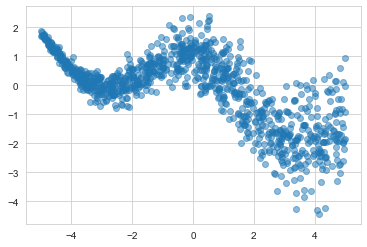

In [4]:
# visualize the data
import seaborn as sns
sns.set_style('whitegrid')
x, y = generate_batch(1024)
plt.scatter(x, y, alpha=0.5)

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.ann1 = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(), 
            nn.Linear(10, 1)
        )
        self.ann2 = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(), 
            nn.Linear(10, 1)
        )
    
    def forward(self, inputs):
        # returns (mean, log-variance)
        return self.ann1(inputs), self.ann2(inputs)

In [10]:
model = Model()

In [11]:
def criterion(outputs, targets):
    mu = outputs[0]
    v = torch.exp(outputs[1])
    
    # coefficient term
    c = torch.log(torch.sqrt(2 * np.pi * v))
    
    # exponent term
    f = 0.5 / v * (targets - mu)**2
    
    # mean log-likelihood
    nll = torch.mean(c + f)
    
    return nll

In [12]:
optimizer = torch.optim.Adam(model.parameters())

In [14]:
n_epochs = 5000
batch_size = 128
losses = np.zeros(n_epochs)
for i in range(n_epochs):
    x, y = generate_batch(batch_size)
    
    # convert to torch tensor
    inputs = torch.from_numpy(x).float()
    targets = torch.from_numpy(y).float()
    
    # reshape the data
    inputs, targets = inputs.view(-1, 1), targets.view(-1, 1)
    
    # zero the gradients
    optimizer.zero_grad()
    
    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # store the loss
    losses[i] = loss.item()
    
    # print the loss
    if i % 500 == 0:
        print(f'epoch: {i+500}/{n_epochs}, loss: {losses[i]}')
        
    # optimize the parameters
    loss.backward()
    optimizer.step()

epoch: 500/5000, loss: 0.6419294476509094
epoch: 1000/5000, loss: 0.606961190700531
epoch: 1500/5000, loss: 0.641319990158081
epoch: 2000/5000, loss: 0.5394394397735596
epoch: 2500/5000, loss: 0.6000362038612366
epoch: 3000/5000, loss: 0.6351561546325684
epoch: 3500/5000, loss: 0.5986248254776001
epoch: 4000/5000, loss: 0.8384619355201721
epoch: 4500/5000, loss: 0.5903037190437317
epoch: 5000/5000, loss: 0.5552106499671936


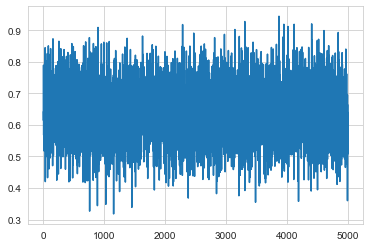

In [16]:
# plot the losses
plt.plot(losses)

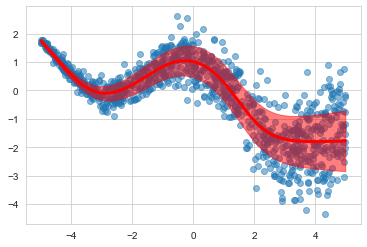

In [17]:
# plot the model predictions
x, y = generate_batch(1024)
plt.scatter(x, y, alpha=0.5)

# convert to torch tensor
inputs = torch.from_numpy(x).float()
targets = torch.from_numpy(y).float()

# reshape the data
inputs, targets = inputs.view(-1, 1), targets.view(-1, 1)

with torch.no_grad():
    outputs = model(inputs)
    yhat = outputs[0].numpy().flatten()
    sd = np.exp(outputs[1].numpy().flatten() / 2)
    
idx = np.argsort(x)
plt.plot(x[idx], yhat[idx], linewidth=3, color='red')
plt.fill_between(x[idx], yhat[idx]-sd[idx], yhat[idx]+sd[idx], color='red', alpha=0.5)